# Decomposition method

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations, DeepQLearning
using AutomotiveDrivingModels,AutoViz
using Reel 

In [2]:
include("AutomotivePOMDPs.jl")
using AutomotivePOMDPs


In [3]:
rng = MersenneTwister(1);


## Initialize

In [4]:
params = UrbanParams()
env = UrbanEnv(params=params)
obs_dist = ObstacleDistribution(env)
pomdp = UrbanPOMDP(env=env, obs_dist=obs_dist, max_peds=5, max_cars=5, ped_birth=0.5)

AutomotivePOMDPs.UrbanPOMDP
  env: AutomotivePOMDPs.UrbanEnv
  obs_dist: AutomotivePOMDPs.ObstacleDistribution
  sensor: AutomotiveDrivingModels.LidarSensor
  models: Dict{Int64,AutomotiveDrivingModels.DriverModel}
  ego_type: AutomotiveDrivingModels.VehicleDef
  car_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  max_cars: Int64 5
  max_peds: Int64 5
  obstacles: Bool true
  max_acc: Float64 2.0
  ego_start: Float64 17.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2{Float64}
  ΔT: Float64 0.5
  car_birth: Float64 0.3
  ped_birth: Float64 0.5
  a_noise: Float64 1.0
  v_noise: Float64 1.0
  pos_obs_noise: Float64 0.5
  vel_obs_noise: Float64 0.5
  collision_cost: Float64 -1.0
  action_cost: Float64 0.0
  goal_reward: Float64 1.0
  γ: Float64 0.95


Load Policies

In [ ]:
obsped_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_drqn/obsped4/problem.jld", weights_file = "../maximeworkspace/urban_drqn/obsped4/weights.jld")

obscar_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_drqn/obscar4/problem.jld", weights_file = "../maximeworkspace/urban_drqn/obscar4/weights.jld")
pedcar_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_drqn/pedcar4/problem.jld", weights_file = "../maximeworkspace/urban_drqn/pedcar4/weights.jld")
twocars_policy = DeepQLearning.restore(problem_file = "../maximeworkspace/urban_drqn/twocars4/problem.jld", weights_file = "../maximeworkspace/urban_drqn/twocars4/weights.jld")
;

2018-03-20 23:48:39.458352: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [ ]:
policy_map = Dict(:obsped=>obsped_policy,
                  :obscar=>obscar_policy,
                  :pedcar=>pedcar_policy,
                  :twocars=>twocars_policy
    )
problem_map = Dict(:obsped=>ObsPed,
                   :obscar=>ObsCar,
                   :pedcar=>PedCar,
                   :twocars=>TwoCars)
;

In [ ]:
function fusion_min(x)
    return minimum(hcat(x), 2)
end
MIN = x -> minimum(vcat(x...), 1)
SUM = x -> sum(vcat(x...), 1)

In [ ]:
dec_policy = DecomposedPolicy(pomdp, problem_map, policy_map, MIN, actions(pomdp));

In [ ]:
function reset_dec_policy!(policy::DecomposedPolicy)
    for (prob_key, sub_policy) in policy.policy_map
        DeepQLearning.reset_hidden_state!(sub_policy)
    end
end


Set up the k-Markov updater

In [ ]:
up = KMarkovDecUpdater(KMarkovUpdater(4), pomdp);
up = PreviousObsDecUpdater(FastPreviousObservationUpdater{Vector{Float64}}(), pomdp);

In [ ]:
include("decomposition/rendering.jl")

In [ ]:
reset_dec_policy!(dec_policy)
s0 = initial_state(pomdp, rng)
b0 = initialize_dec_belief(up, pomdp, s0, rng);
hr = HistoryRecorder(rng=rng, initial_state = s0, max_steps=100);
@time hist = simulate(hr, pomdp, dec_policy, up, b0);

In [ ]:
push!(hist.action_hist, UrbanAction(0.))
action_hist = [a.acc for a in hist.action_hist]
duration, fps, render_hist = animate_scenes(hist.state_hist,
                                            action_hist,
                                            hist.belief_hist,
                                            dec_policy,
                                            pomdp.env, 
                                            overlays = SceneOverlay[IDOverlay()], 
                                            sim_dt=pomdp.ΔT, 
                                            cam=StaticCamera(VecE2(0.,-10.), 14.))
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

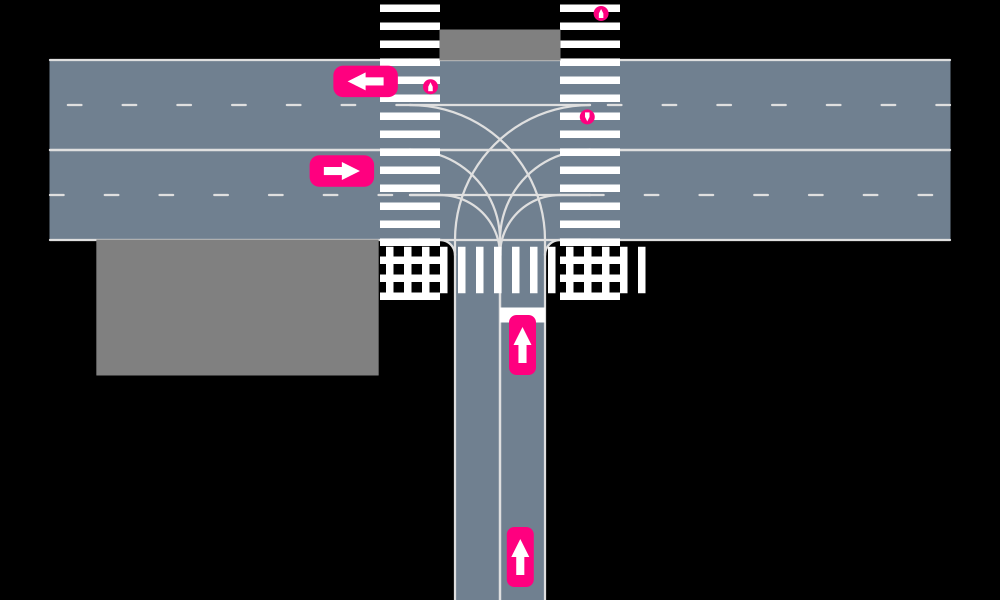

In [67]:
scene = obs_to_scene(pomdp, hist.observation_hist[1])
AutoViz.render(scene, pomdp.env, cam=FitToContentCamera(0.))

In [102]:
o = generate_o(pomdp, s0, rng)

56-element Array{Float64,1}:
  0.0625  
 -0.541667
  1.0     
  0.0     
 -0.102705
 -0.183794
  0.0     
  0.471932
 -1.16667 
 -1.2125  
  0.0     
  0.0     
 -1.16667 
  ⋮       
  0.78125 
  0.375   
 -0.729167
 -0.4375  
  0.260417
  0.375   
  0.729167
 -0.4375  
 -1.16667 
 -1.2125  
  0.0     
  0.0     

In [78]:
max_ego_dist = get_end(pomdp.env.roadway[pomdp.ego_goal])
[-28, -29.2,0]/24

3-element Array{Float64,1}:
 -1.16667
 -1.21667
  0.0    

In [103]:
i = 11
println("indices:", 4*(i-1)+1, ", ", 4*i)
o[4*(i-1)+1:4*i]#.*[24,24,pi,24]

indices:41, 44


4-element Array{Float64,1}:
 -0.0486111
 -0.0505208
  0.0      
  0.0      

In [79]:
car_map

Dict{String,Array{Float64,1}} with 5 entries:
  "car5" => [-0.439306, -0.0583882, 0.0, 0.0713542]
  "car3" => [0.0563329, -1.13056, 0.5, 0.285223]
  "car4" => [-0.373311, 0.190576, 1.0, 0.81172]
  "car1" => [-1.16667, -1.2125, 0.0, 0.0]
  "car2" => [-1.16667, -1.2125, 0.0, 0.0]

In [80]:
ped_map

Dict{String,Array{Float64,1}} with 5 entries:
  "ped5" => [-0.0486111, -0.0505208, 0.0, 0.0]
  "ped4" => [-0.193091, 0.175828, 0.5, 0.137288]
  "ped2" => [0.280848, 0.379227, 0.5, 0.0890329]
  "ped1" => [0.242414, 0.0919097, 1.5, -0.0349959]
  "ped3" => [-1.16667, -1.2125, 0.0, 0.0]

In [70]:
scene = Scene()
feature_vec = nothing
ego, car_map, ped_map, obs_map = AutomotivePOMDPs.split_o(hist.observation_hist[1], pomdp)
for (ped, ped_state) in ped_map
    println(ped_state)
    obs_states = []
    for (obs, obs_state) in obs_map
        push!(obs_states, obs_state)

    end
    feature_vec = vcat(ego, ped_state, obs_states...)
end

[-0.0486111, -0.0505208, 0.0, 0.0]
[-0.193091, 0.175828, 0.5, 0.137288]
[0.280848, 0.379227, 0.5, 0.0890329]
[0.242414, 0.0919097, 1.5, -0.0349959]
[-1.16667, -1.2125, 0.0, 0.0]


In [25]:
hist.observation_hist[1][(1+pomdp.max_cars)*4+1:(1+pomdp.max_cars)*4+4]

4-element Array{Float64,1}:
  0.0254089
 -0.270342 
  1.0      
  0.0761588

In [37]:
hist.belief_hist[1][2][2]

20-element Array{Float64,1}:
  0.0625   
 -0.541667 
  1.0      
  0.0      
  0.205779 
  0.261298 
  1.5      
  0.023842 
  0.520833 
  0.375    
 -0.729167 
 -0.4375   
  0.0833333
  0.0833333
  0.0      
  0.291667 
  0.260417 
  0.375    
  0.729167 
 -0.4375   

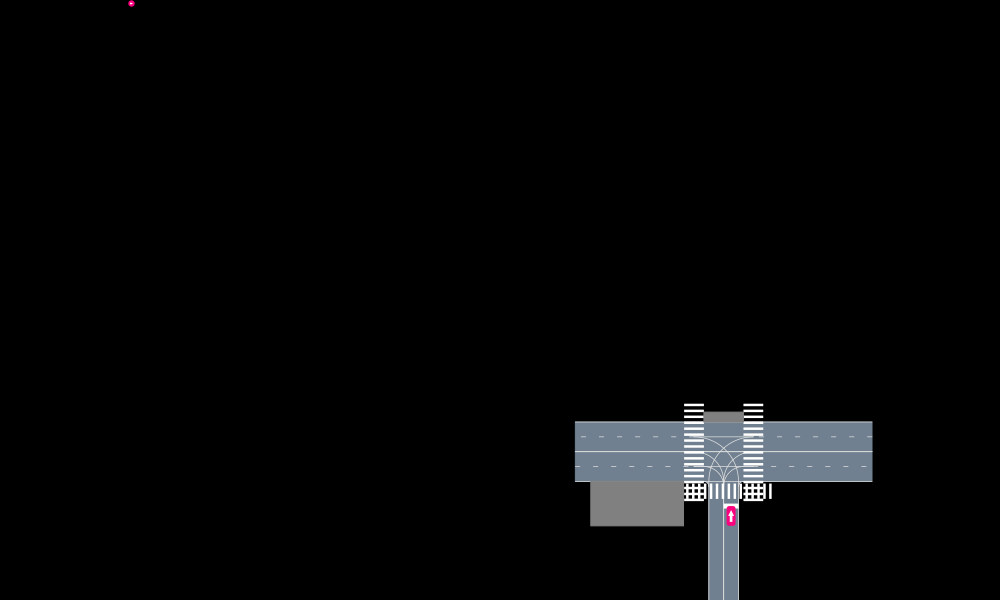

In [44]:
s1 = obs_to_scene(ObsPed, hist.belief_hist[1][2][2])
AutoViz.render(s1, pomdp.env, cam=FitToContentCamera(0.))

In [32]:
methods(obs_to_scene)

# 2 methods for generic function "obs_to_scene":
obs_to_scene(pomdp::AutomotivePOMDPs.UrbanPOMDP, obs::Array{Float64,1}) in AutomotivePOMDPs at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotivePOMDPs/urban/generative_model.jl:508
obs_to_scene(pomdp::AutomotivePOMDPs.OIPOMDP, o::Array{Float64,1}) in AutomotivePOMDPs at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotivePOMDPs/multi_lane_T_intersection/generative_model.jl:271

In [15]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene},
                        actions::Vector{Float64},
                        env;
                        overlays::Vector{SceneOverlay} = SceneOverlay[],
                        cam=FitToContentCamera(0.),
                        sim_dt=0.1)
    duration =length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    cam = FitToContentCamera(0.)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        return AutoViz.render(scenes[frame_index], 
                              env,
                              cat(1, overlays, TextOverlay(text = ["Acc: $(actions[frame_index])"])),
                              cam=cam,
                              car_colors=get_colors(scenes[frame_index]))
    end
    return duration, fps, render_rec
end

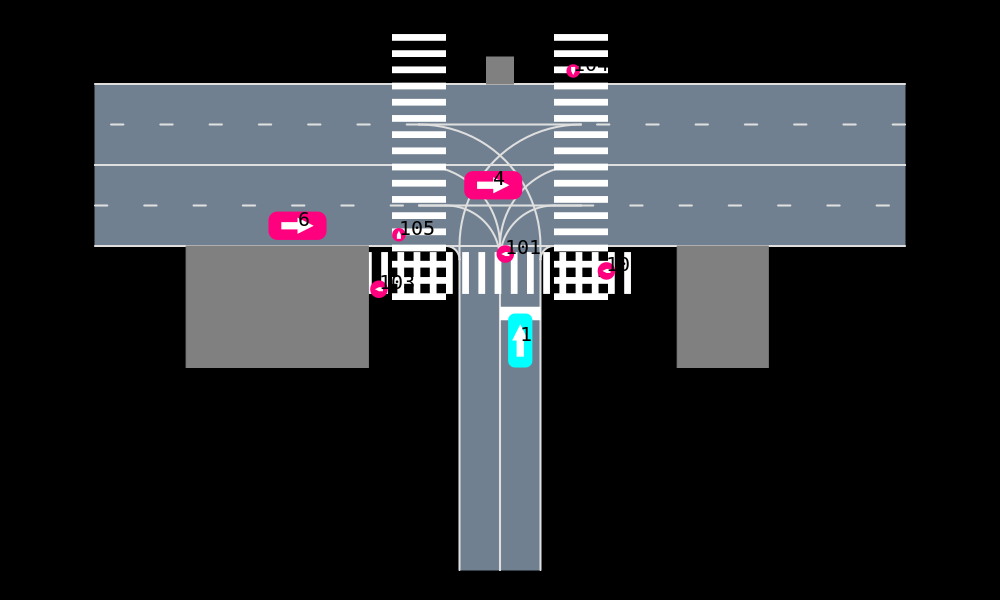

In [12]:
AutoViz.render(s, env, cam=FitToContentCamera(),[IDOverlay()], car_colors=get_colors(s))